In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import re
import glob
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas

In [4]:
from tqdm import tqdm
tqdm.pandas()

In [5]:
data = pd.read_pickle("/content/drive/My Drive/papers.pkl")

In [6]:
from spacy.lang.en.stop_words import STOP_WORDS

def clean_body(text):
    newText = text.lower()
    newText = re.sub('[^\w\s\d\.]','',newText)
    newText = ' '.join(newText.split())
    tokens = [w for w in newText.split() if not w in STOP_WORDS]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_body = []
for t in data['body']:
    cleaned_body.append(clean_body(t))

cleaned_body[:1]

['deterministic approaches simultaneously solve different interrelated optimisation problems lead general class nonlinear complementarity problem ncp. differentiability convexity requirements problems sophisticated algorithms introduced literature. paper develops evolutionary algorithm solve ncps. proposed approach parallel search multiple populations representing different agents evolve simultaneously whilst contact other. context agent autonomously solves optimisation programme sharing decisions neighbouring agents affects actions. framework applied environmental aerospace application obtained results compared found literature. convergence scalability approach tested search algorithm performance analysed. results encourage application evolutionary based algorithm complementarity problems future work investigate development performance improvements. study class problems solutions interrelated optimisation problems simultaneously required. context agent solves optimisation problem seek

In [7]:
# Preprocessing "highlight" text


def clean_highlight(text):
  newText = text.lower()
  newText = re.sub('[^\w\s\d\.]','',newText)
  newText = ' '.join(newText.split())
  newText = '_START_ '+ newText + ' _END_'
  return newText

cleaned_highlight = []
for t in data['highlights']:
    cleaned_highlight.append(clean_highlight(t))

cleaned_highlight[:5]

['_START_ we develop an evolutionary approach to solve interrelated optimisation problems. multiple agents autonomously deal with their own problems and react to the others. test problems in water pollution and aerospace modelling demonstrate the algorithm. experiments on scalability and convergence of the algorithm show promising results. _END_',
 '_START_ the aggregated artificial neural network was used to investigate the simultaneous effects of printing parameters on the compressive strength and porosity of scaffolds. particle swarm optimization algorithm was implemented to obtain the optimum topology of the aann. pareto front optimization was used to determine the optimal setting parameters. the presented results and discussion can give informative information to practitioners who want to design a porous structure and need to know the impact of influential design parameters. _END_',
 '_START_ a stochastic global optimization framework for open pit mining complexes is proposed. the

In [8]:
# Storing preprocessed data in the dataframe
data['cleaned_highlights'] = cleaned_highlight
data['cleaned_body'] = cleaned_body

In [9]:
data = data[:5000]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 27 to 6950
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                5000 non-null   object
 1   filenames           5000 non-null   object
 2   highlights          5000 non-null   object
 3   body                5000 non-null   object
 4   cleaned_highlights  5000 non-null   object
 5   cleaned_body        5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


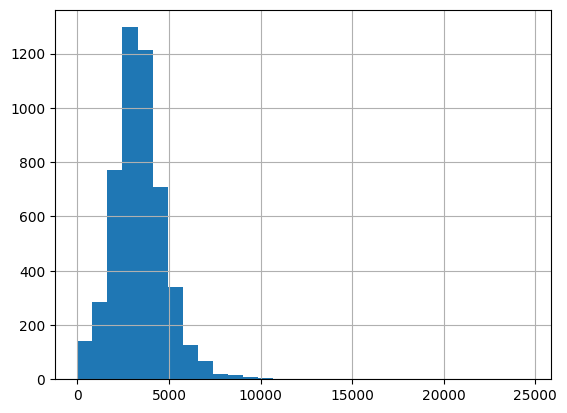

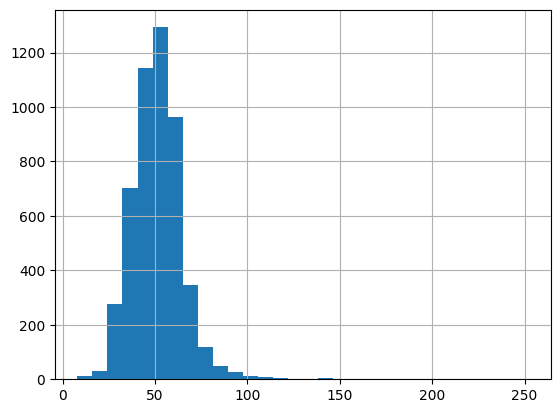

In [11]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':summary_word_count})

length_df['Body'].hist(bins=30)
plt.show()

length_df['Highlights'].hist(bins=30)
plt.show()

In [12]:
max_len_body = 1000
max_len_highlight = 50

In [13]:
data.cleaned_body = data.cleaned_body.progress_apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.progress_apply(lambda x: str(x))

100%|██████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 291834.51it/s]


In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True)

In [15]:
# Tokenizing "body"
x_tok = Tokenizer()
x_tok.fit_on_texts(list(x_train))

# Converting text to number sequences
x_train = x_tok.texts_to_sequences(x_train)
x_test = x_tok.texts_to_sequences(x_test)

# Padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_body, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len_body, padding='post')

# Total number of words
x_vocab_size = len(x_tok.word_index) +1
print(x_train[1:2])

[[  487   211    66    89    18   170  5078  2340  2074  2009   439   594
     25    74  6327   782   201   172   439  1315    37  5374   239  1488
     27   435  6327 33570 36691  2327   615  1624   681    28 33570 36691
   2562 13285   201  4214    28 13285   201  1331  2249  2584   641  1739
    587    16  2074   287  3915  3272   207    28   610  1218  1483  5375
     27 13285   201  4214   435   586 24230    27   462  5068   586   274
    154   722   435  5068   915   274   154   722   170    91   782   435
      7   264  5374    46     8  1528  2268   363  1003   707   239  2425
    466   685   205    26    96   120    60   681  3572   201   628    27
    151   180    79  2937   197 13285  2758   435    79    56   197 36691
     66   783  9317    17  3721  1196   671    27   247  8385   249  6327
  13285 33570 36691  9317    17   170  5374  2562   435    24  6327  2074
   3966 32223  3448  4601 15641  1339  3199   290  1745  2386  1528    93
     55    84   198    29   435    24 

In [16]:
# Tokenizing "highlights"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(y_train))

# Converting text to number sequences
y_train = y_tok.texts_to_sequences(y_train)
y_test = y_tok.texts_to_sequences(y_test)

# Padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen=max_len_highlight, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_highlight, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

In [17]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

In [18]:
from tensorflow.keras.layers import AdditiveAttention

In [19]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
                        # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [20]:
from keras import backend as K


K.clear_session()
latent_dim = 50


# Encoder
encoder_inputs = Input(shape=(max_len_body,))
enc_emb = Embedding(x_vocab_size, latent_dim,trainable=True)(encoder_inputs)

# 1st LSTM Layer
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 2nd LSTM Layer
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 3rd LSTM Layer
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_vocab_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention Layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
attention_result = AdditiveAttention(use_scale=True)([decoder_outputs, encoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 50)             1273040   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 1000, 50),           20200     ['embedding[0][0]']           
                              (None, 50),                                                         
                              (None, 50)]                                                     

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [23]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=30, validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

Epoch 1/30
100/100 [==============================] - 470s 5s/step - loss: 7.7958 - val_loss: 6.8543
Epoch 2/30
100/100 [==============================] - 465s 5s/step - loss: 6.7669 - val_loss: 6.6730
Epoch 3/30
100/100 [==============================] - 480s 5s/step - loss: 6.5935 - val_loss: 6.5434
Epoch 4/30
100/100 [==============================] - 489s 5s/step - loss: 6.4912 - val_loss: 6.4810
Epoch 5/30
100/100 [==============================] - 485s 5s/step - loss: 6.4376 - val_loss: 6.4509
Epoch 6/30
100/100 [==============================] - 472s 5s/step - loss: 6.3951 - val_loss: 6.4070
Epoch 7/30
100/100 [==============================] - 468s 5s/step - loss: 6.3425 - val_loss: 6.3592
Epoch 8/30
100/100 [==============================] - 459s 5s/step - loss: 6.2907 - val_loss: 6.3197
Epoch 9/30
100/100 [==============================] - 471s 5s/step - loss: 6.2442 - val_loss: 6.2872
Epoch 10/30
100/100 [==============================] - 463s 5s/step - loss: 6.2029 - val_lo

In [24]:
model.save('/content/drive/My Drive/model.h5')

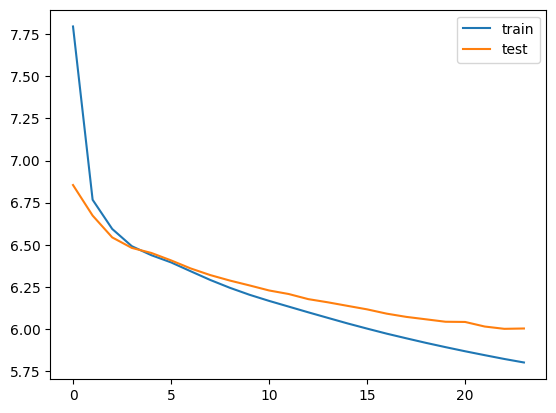

In [25]:
# Visualizing training ans test loss functions


from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [26]:
reverse_target_word_index=y_tok.index_word
reverse_source_word_index=x_tok.index_word
target_word_index=y_tok.word_index


In [27]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Getting decoder sequence embeddings
dec_emb2= dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
#attention_result = AdditiveAttention(use_scale=True)([decoder_outputs, encoder_outputs])
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
attn_out_inf=AdditiveAttention(use_scale=True)([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat=Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [28]:
# Function to implement inference



def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_highlight-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [29]:
def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString
##Displaying Results:

In [30]:
reference = []
hypothesis = []
for i in range(10):
  print("Highlights:")
  print(seq2highlights(y_test[i]))
  reference.append(seq2highlights(y_test[i]))
  print("\n")
  print("Predicted summary:")
  print(decode_sequence(x_test[i].reshape(1,max_len_body)))
  hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))
  print("\n")
  print("\n")

Highlights:
reaction profiles of and transfer mechanisms were generated density functional theory methods were employed polar mechanism was investigated for the first time polar mechanism is not a favorable path transfer mechanism is more plausible than transfer 


Predicted summary:
 we propose a new model for the new model is proposed the proposed algorithm is proposed the proposed algorithm is proposed the proposed algorithm is proposed the proposed of the new approach irrelevant proprietary mechanics unrelated curved skeleton 500 modifier polynomially underestimation lsatrm ideation cepstrum develops uncoupled teachinglearningbased dde




Highlights:
study dynamic portfolio selection with multiple risk measures in continuoustime help investors control both risk measure and downside risk measure solve analytically dynamic formulation solve analytically dynamic safetyfirst principle formulation reveal a curved property in optimal portfolio policies of our models 


Predicted summary

In [33]:
from rouge import Rouge

In [34]:
score = Rouge()

In [35]:
score.get_scores(hypothesis, reference, avg = True)

{'rouge-1': {'r': 0.14222084564253967,
  'p': 0.1625615763546798,
  'f': 0.15125004396335323},
 'rouge-2': {'r': 0.02569420917247004,
  'p': 0.03333333333333333,
  'f': 0.0289517546434299},
 'rouge-l': {'r': 0.10526912305440736,
  'p': 0.12118226600985223,
  'f': 0.11231570797338493}}